In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pyale

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install rdkit-pypi

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

from sklearn.model_selection import KFold, cross_val_score, ParameterGrid
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np
np.int = int
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.utils import shuffle
import shap
shap.initjs()
from PyALE import ale
from scipy.stats import friedmanchisquare
import itertools
from rdkit import Chem
from rdkit.Chem import AllChem

In [52]:
#read input data
df_input = pd.read_csv('input_single.csv', index_col=0)
df_input = df_input.transpose()

# ECFP fingerprints calculation
def compute_ecfp(smiles):
    if smiles is not None:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            return ecfp.ToBitString()
    return None

# Apply the function to the 'SMILES' column and create a new column for ECFP fingerprints

df_input['ECFP main']=df_input['SMILES main compound acid'].apply(lambda x: compute_ecfp(x) if pd.notna(x) else None)

ecfp_main_real = PCA(n_components=1).fit_transform(df_input['ECFP main'].apply(lambda x: pd.Series(map(float, x)) if pd.notna(x) else None))
df_input.insert(loc=df_input.columns.get_loc('SMILES main compound acid'), column='ECFP main real', value=ecfp_main_real)

df_input = df_input.transpose()

#filter input data
indices_to_remove_input = ['experimentalist', 'name main compund acid', 'c total', 'SMILES main compound acid', 'name 2nd compound acid', 'SMILES 2nd compound acid', 'name 3rd compound acid', 'SMILES 3rd compound acid', 'time', 'cathode material', 'cathode area [cm^2 ]', 'anode material']
filtered_input = df_input.drop(indices_to_remove_input)
filtered_input = filtered_input.fillna(0) # fill  empty cells with 0
filtered_input = filtered_input.transpose() # change positions of columns and rows
filtered_input = filtered_input.loc[:, :'anode tafel slope pH7 0.25M Na2SO4 [mAcm-2V-1]'] # remove columns after certain column
#print(filtered_input)

#filter output data
df_output = pd.read_csv('input_single.csv', index_col=0)
filtered_output = df_output.loc['acid conversion [%]':, :,] # remove columns after certain column
filtered_output = filtered_output.fillna(0) # fill  empty cells with 0
filtered_output = filtered_output.transpose() # change positions of columns and rows
#print(filtered_output)

output = 'CE alkanes [%]'
output_name = 'CE [%]' # for correlation matrix
X = filtered_input.values
Y = filtered_output[output].values
X = X.astype(float) # change to float for knn
Y = Y.astype(float) # change to float for knn
print(len(filtered_input.iloc[0]))
#print(filtered_input.iloc[0])
features = []
feature_names = ['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment','dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope']
x=0
for i in feature_names:
    features.append(x)
    x += 1
print(len(feature_names))    
#print(features)
#print(len(feature_names))
random_state_counter = 47

25
25


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state_counter)
knn_regressor = Pipeline([
    ('scaler_std', StandardScaler()),
    ('scaler_minmax', MinMaxScaler()),  
    ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance', p=1))
])

knn_regressor.fit(X_train, Y_train)

Y_predict_train_knn = knn_regressor.predict(X_train)
Y_predict_test_knn = knn_regressor.predict(X_test)


mse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn)
rmse_train_knn = mean_squared_error(Y_train, Y_predict_train_knn, squared=False)
r2_train_knn = r2_score(Y_train, Y_predict_train_knn)

mse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn)
rmse_test_knn = mean_squared_error(Y_test, Y_predict_test_knn, squared=False)
r2_test_knn = r2_score(Y_test, Y_predict_test_knn)

print("MSE on train set:", mse_train_knn )
print("RMSE on train set:", rmse_train_knn)
print("R2 on train set:", r2_train_knn)
print("MSE on test set:", mse_test_knn )
print("RMSE on test set:", rmse_test_knn)
print("R2 on test set:", r2_test_knn)


MSE on train set: 0.0
RMSE on train set: 0.0
R2 on train set: 1.0
MSE on test set: 20.18900358019615
RMSE on test set: 4.493217508667497
R2 on test set: 0.9588901066382948


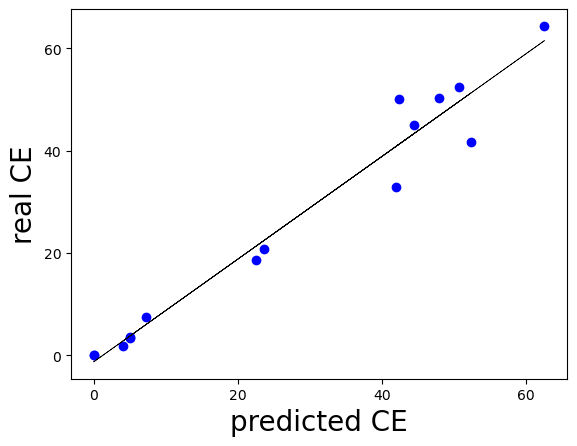

In [24]:
# Linear fit
slope, intercept = np.polyfit(Y_predict_test_knn, Y_test, 1)
fit_line = slope * Y_predict_test_knn + intercept

plt.plot(Y_predict_test_knn, fit_line, color='black', linestyle='-', label='Linear Fit', lw=0.5)
plt.scatter(Y_predict_test_knn, Y_test, color='blue', label='Scatter Points')
#plt.title('Scatter Plot of Y_train vs Y_test')
plt.xlabel('predicted CE', fontsize=20)
plt.ylabel('real CE', fontsize=20)
ticks_interval = 20
if int(min(Y_predict_test_knn)) > int(min(Y_test)):
    min_value = int(min(Y_test))
else:
    min_value = int(min(Y_predict_test_knn))
plt.xticks(np.arange(min_value, int(max(Y_predict_test_knn)) + 6, ticks_interval))
plt.yticks(np.arange(min_value, int(max(Y_test)) + 6, ticks_interval))
#plt.xlim([2, 36])  # Set x-axis range
#plt.ylim([2, 36])  # Set y-axis range
plt.show()

26
['FE', 'c main start', 'ECFP main', 'MW', 'log Kow', 'Tb', 'Tm', 'T_flash', 'density', 'viscosity', 'refraction index', 'pKa', 'dielectric', 'dipole moment', 'dH_f', 'dH_R', 'c 2nd start', 'c 3rd start', 'c Na2SO4', 'pH start', 'k start', 'T start', 'j', 'onset potential', 'tafel slope', 'CE [%]']


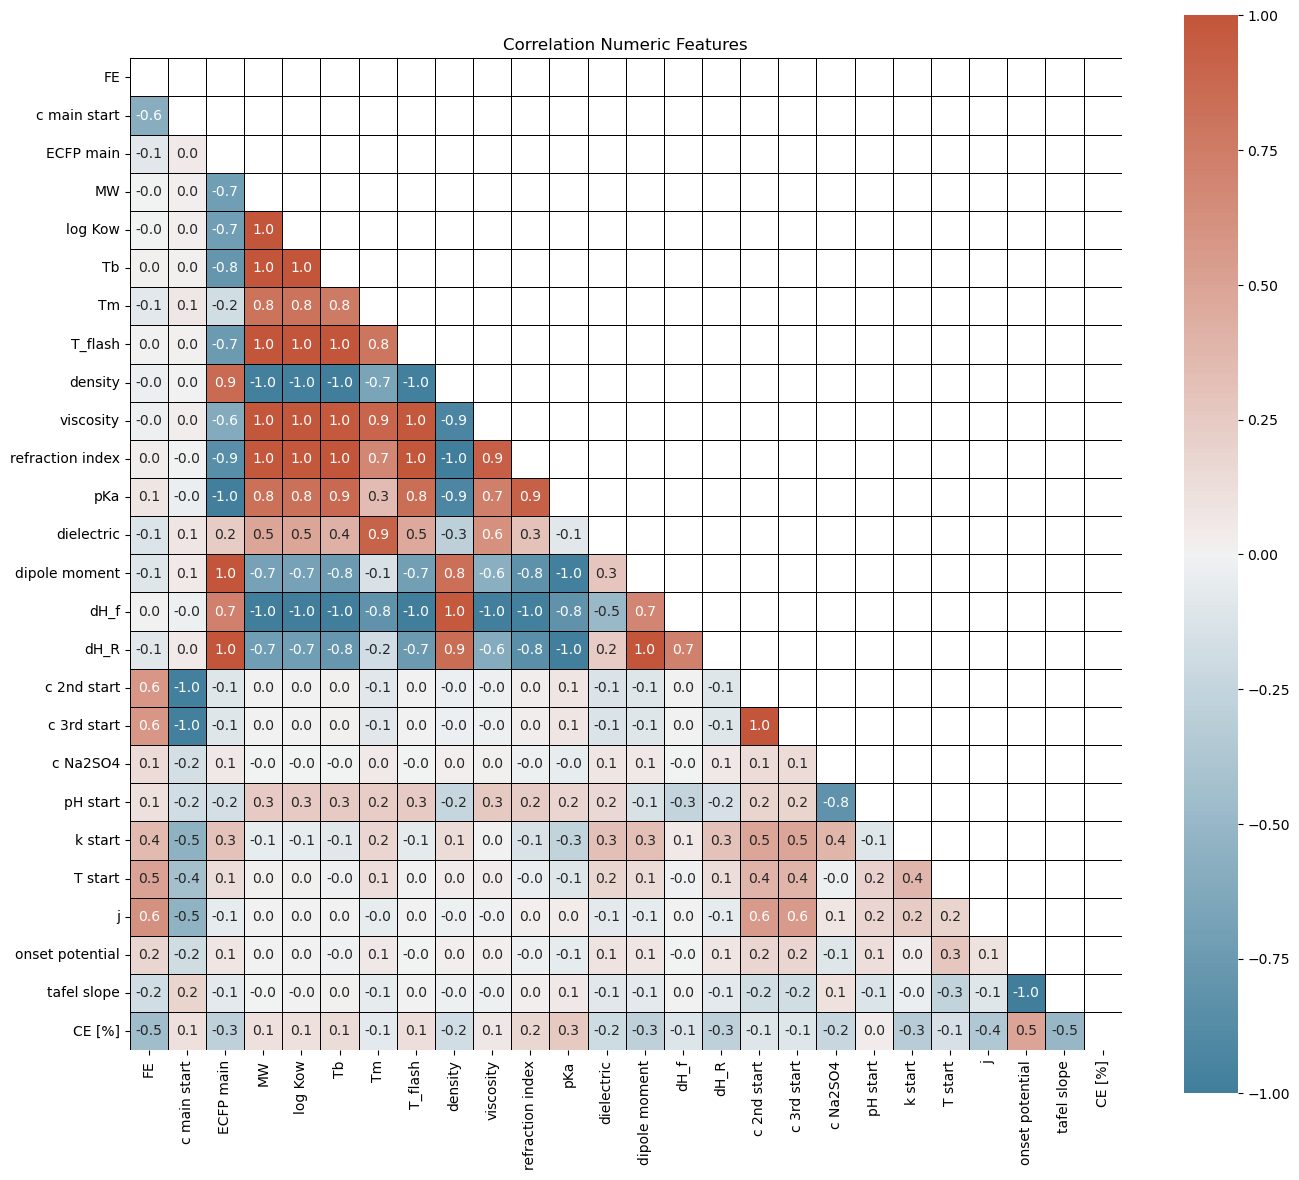

In [9]:
# correlation matrix
feature_namesXY = feature_names.copy()

feature_namesXY.append(output_name)

print(len(feature_namesXY))
print(feature_namesXY)


df_XY = filtered_input
df_XY[output_name] = filtered_output[output]
df_XY.columns = feature_namesXY # change name

corr_df = df_XY.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.1f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

In [10]:
# SHAPLEY values
#explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
#instance_index = 7  # Replace with the index of the instance you want to explain
#shap_value = explainer.shap_values(X_test[instance_index])
#shap.force_plot(explainer.expected_value, shap_value, X_test[instance_index], feature_names=feature_names)

100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


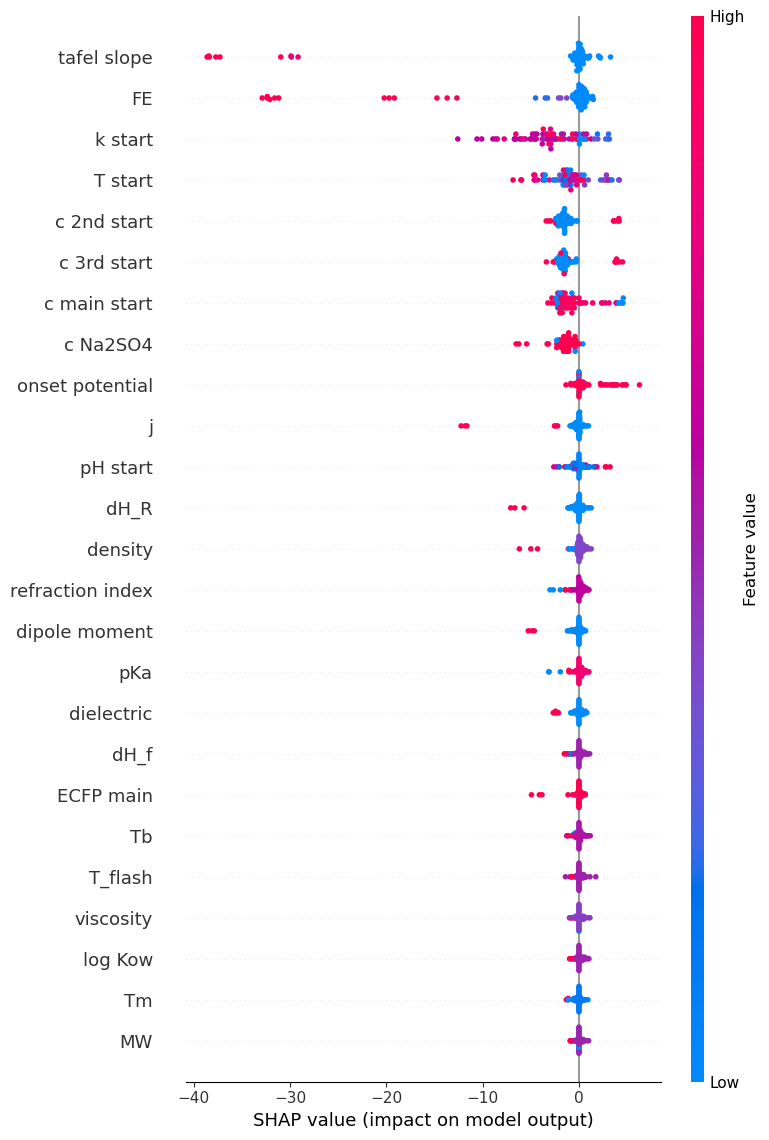

In [57]:
shap_data = X
explainer = shap.KernelExplainer(knn_regressor.predict, X_train)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, max_display=25)

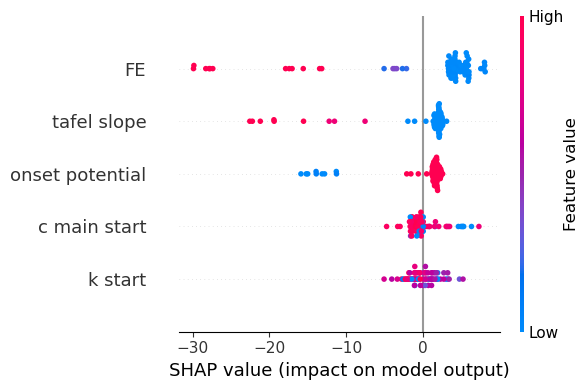

In [30]:
shap.summary_plot(shap_values, shap_data, feature_names=feature_names, max_display=5, plot_size = (6, 4))

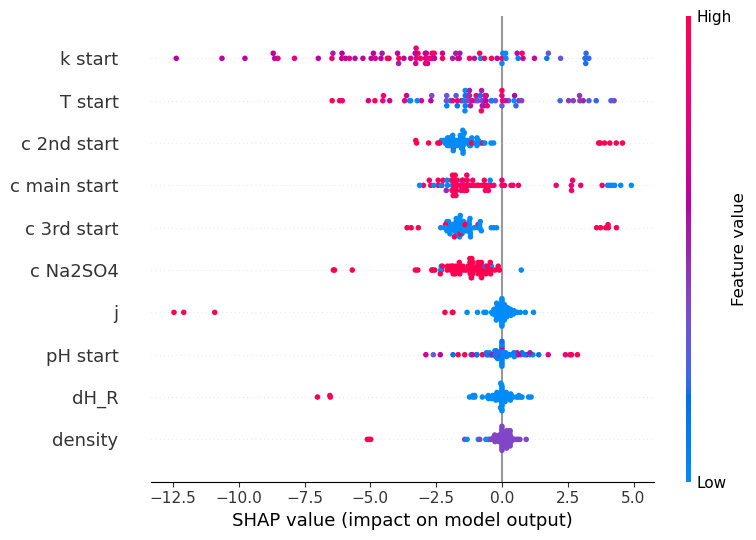

In [56]:
#print(shap_values)
columns_to_drop = ['FE', 'onset potential', 'tafel slope']
df_shap_values = pd.DataFrame(shap_values, columns = feature_names)
df_shap_values = df_shap_values.drop(columns_to_drop, axis=1)
shap_values_selected = df_shap_values.values

df_shap_data = pd.DataFrame(shap_data, columns = feature_names)
df_shap_data = df_shap_data.drop(columns_to_drop, axis=1)
shap_data_selected = df_shap_data.values

#df_shap_values
feature_names_selected = df_shap_values.columns.values

shap.summary_plot(shap_values_selected, shap_data_selected, feature_names=feature_names_selected, max_display=10, #plot_size = (6, 4)
)

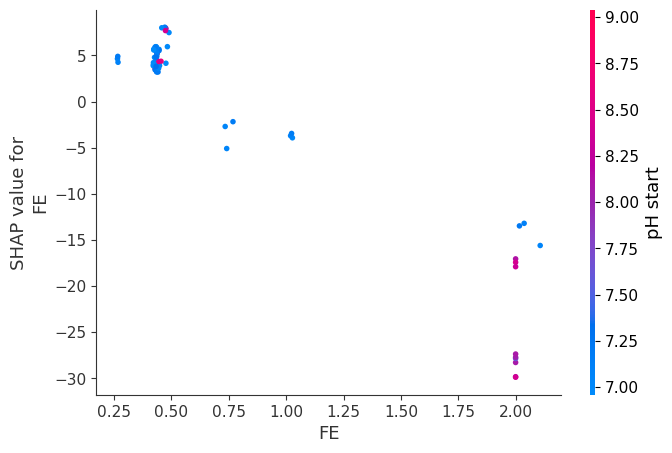

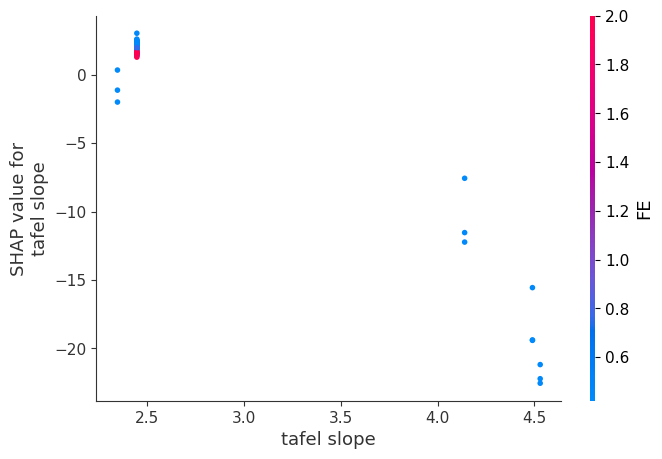

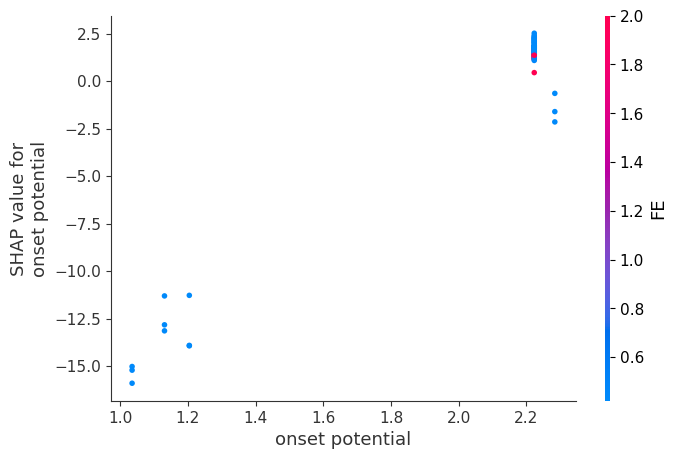

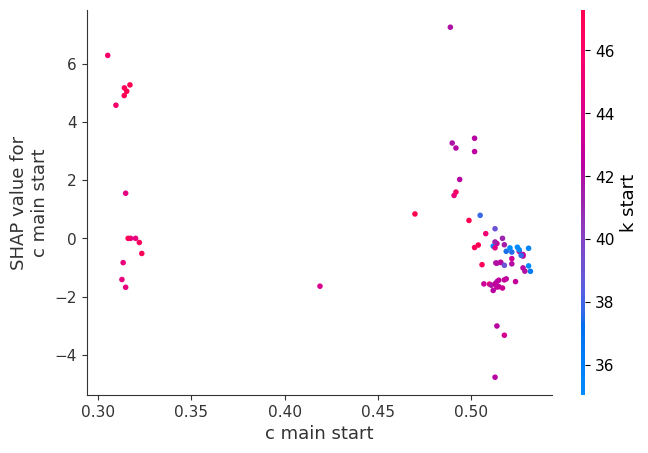

In [12]:
# Create a SHAP dependence plot

feature_index=0
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=24
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=23
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)

feature_index=1
shap.dependence_plot(feature_index, shap_values, shap_data, feature_names=feature_names)


#for i in features:
    #shap.dependence_plot(i, shap_values, shap_data, feature_names=feature_names)

In [13]:
df_test=pd.DataFrame({"test": Y_test, "prediction": Y_predict_test_knn})
print(df_test)

      test  prediction
0   52.509   50.632954
1   50.261   47.867943
2    1.900    4.096875
3   20.746   23.674817
4   45.032   44.454375
5    3.573    5.059555
6    3.414    5.026182
7    0.000    0.000000
8    0.000    0.000000
9    7.497    7.303896
10  41.668   52.357792
11  32.828   41.921294
12  64.388   62.529406
13  50.029   42.326864
14  18.629   22.536394


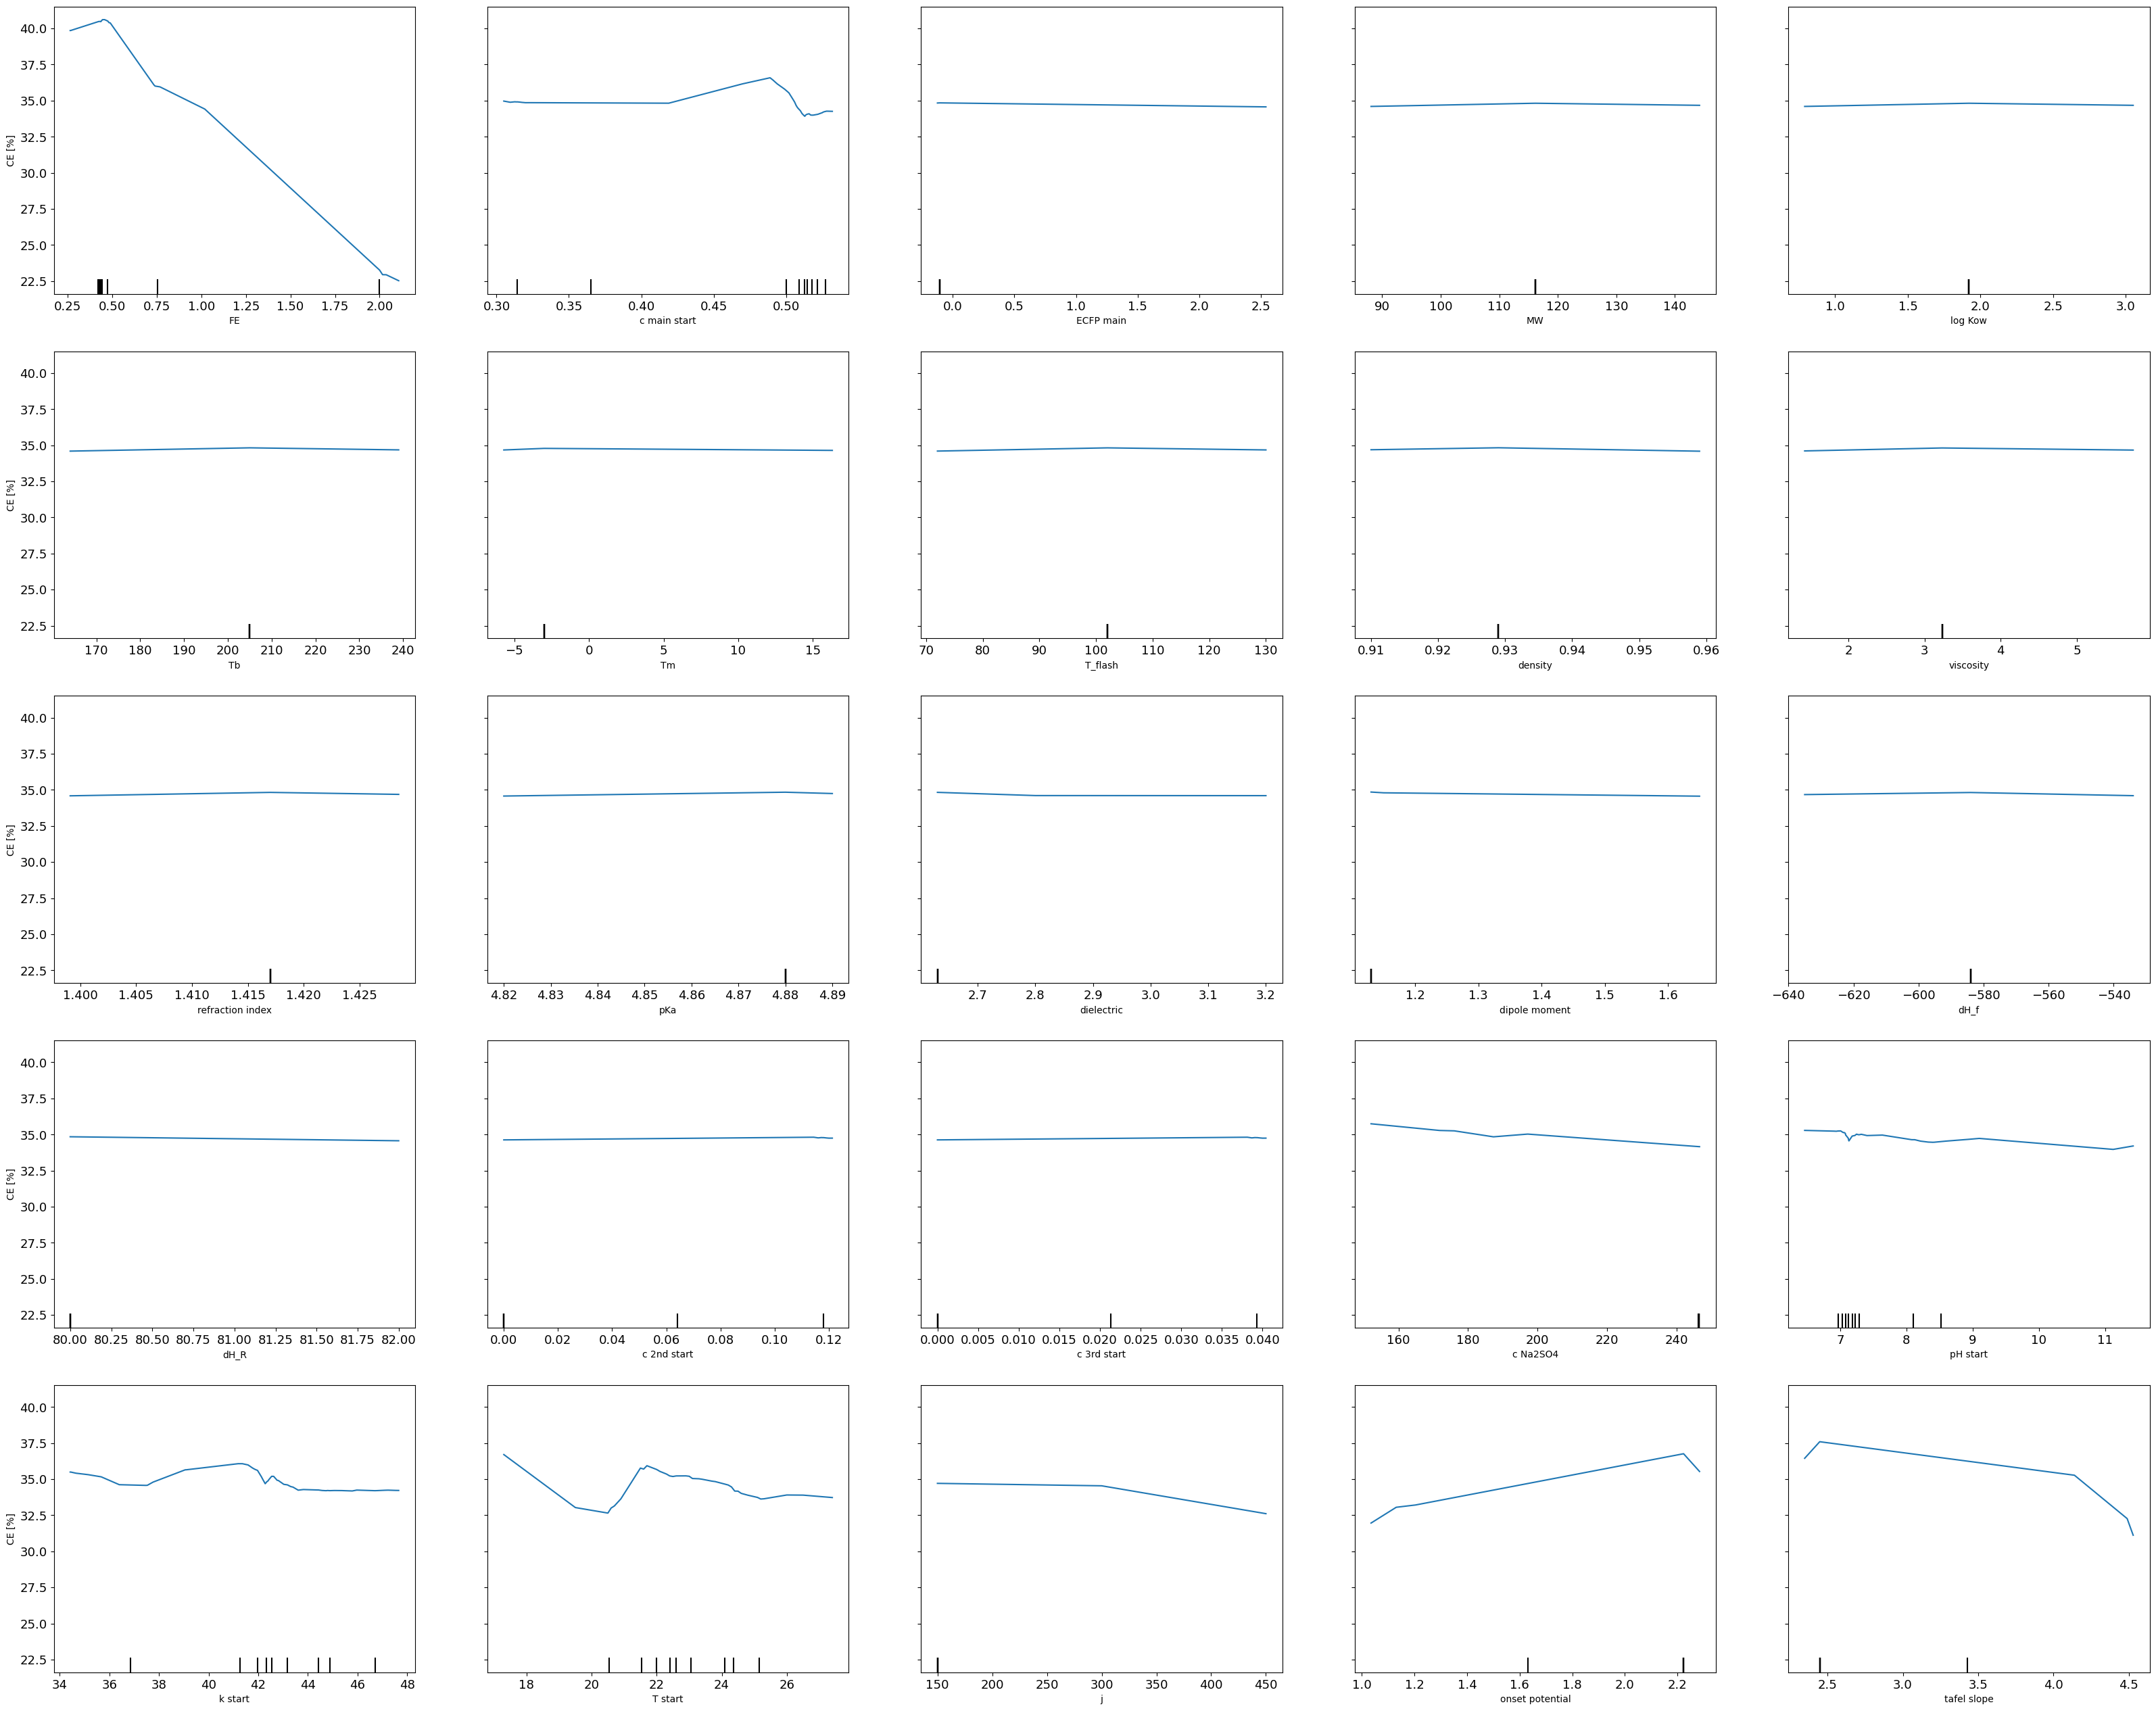

In [14]:
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, ax=ax#, line_kw={"color": "green"}
                                                 )

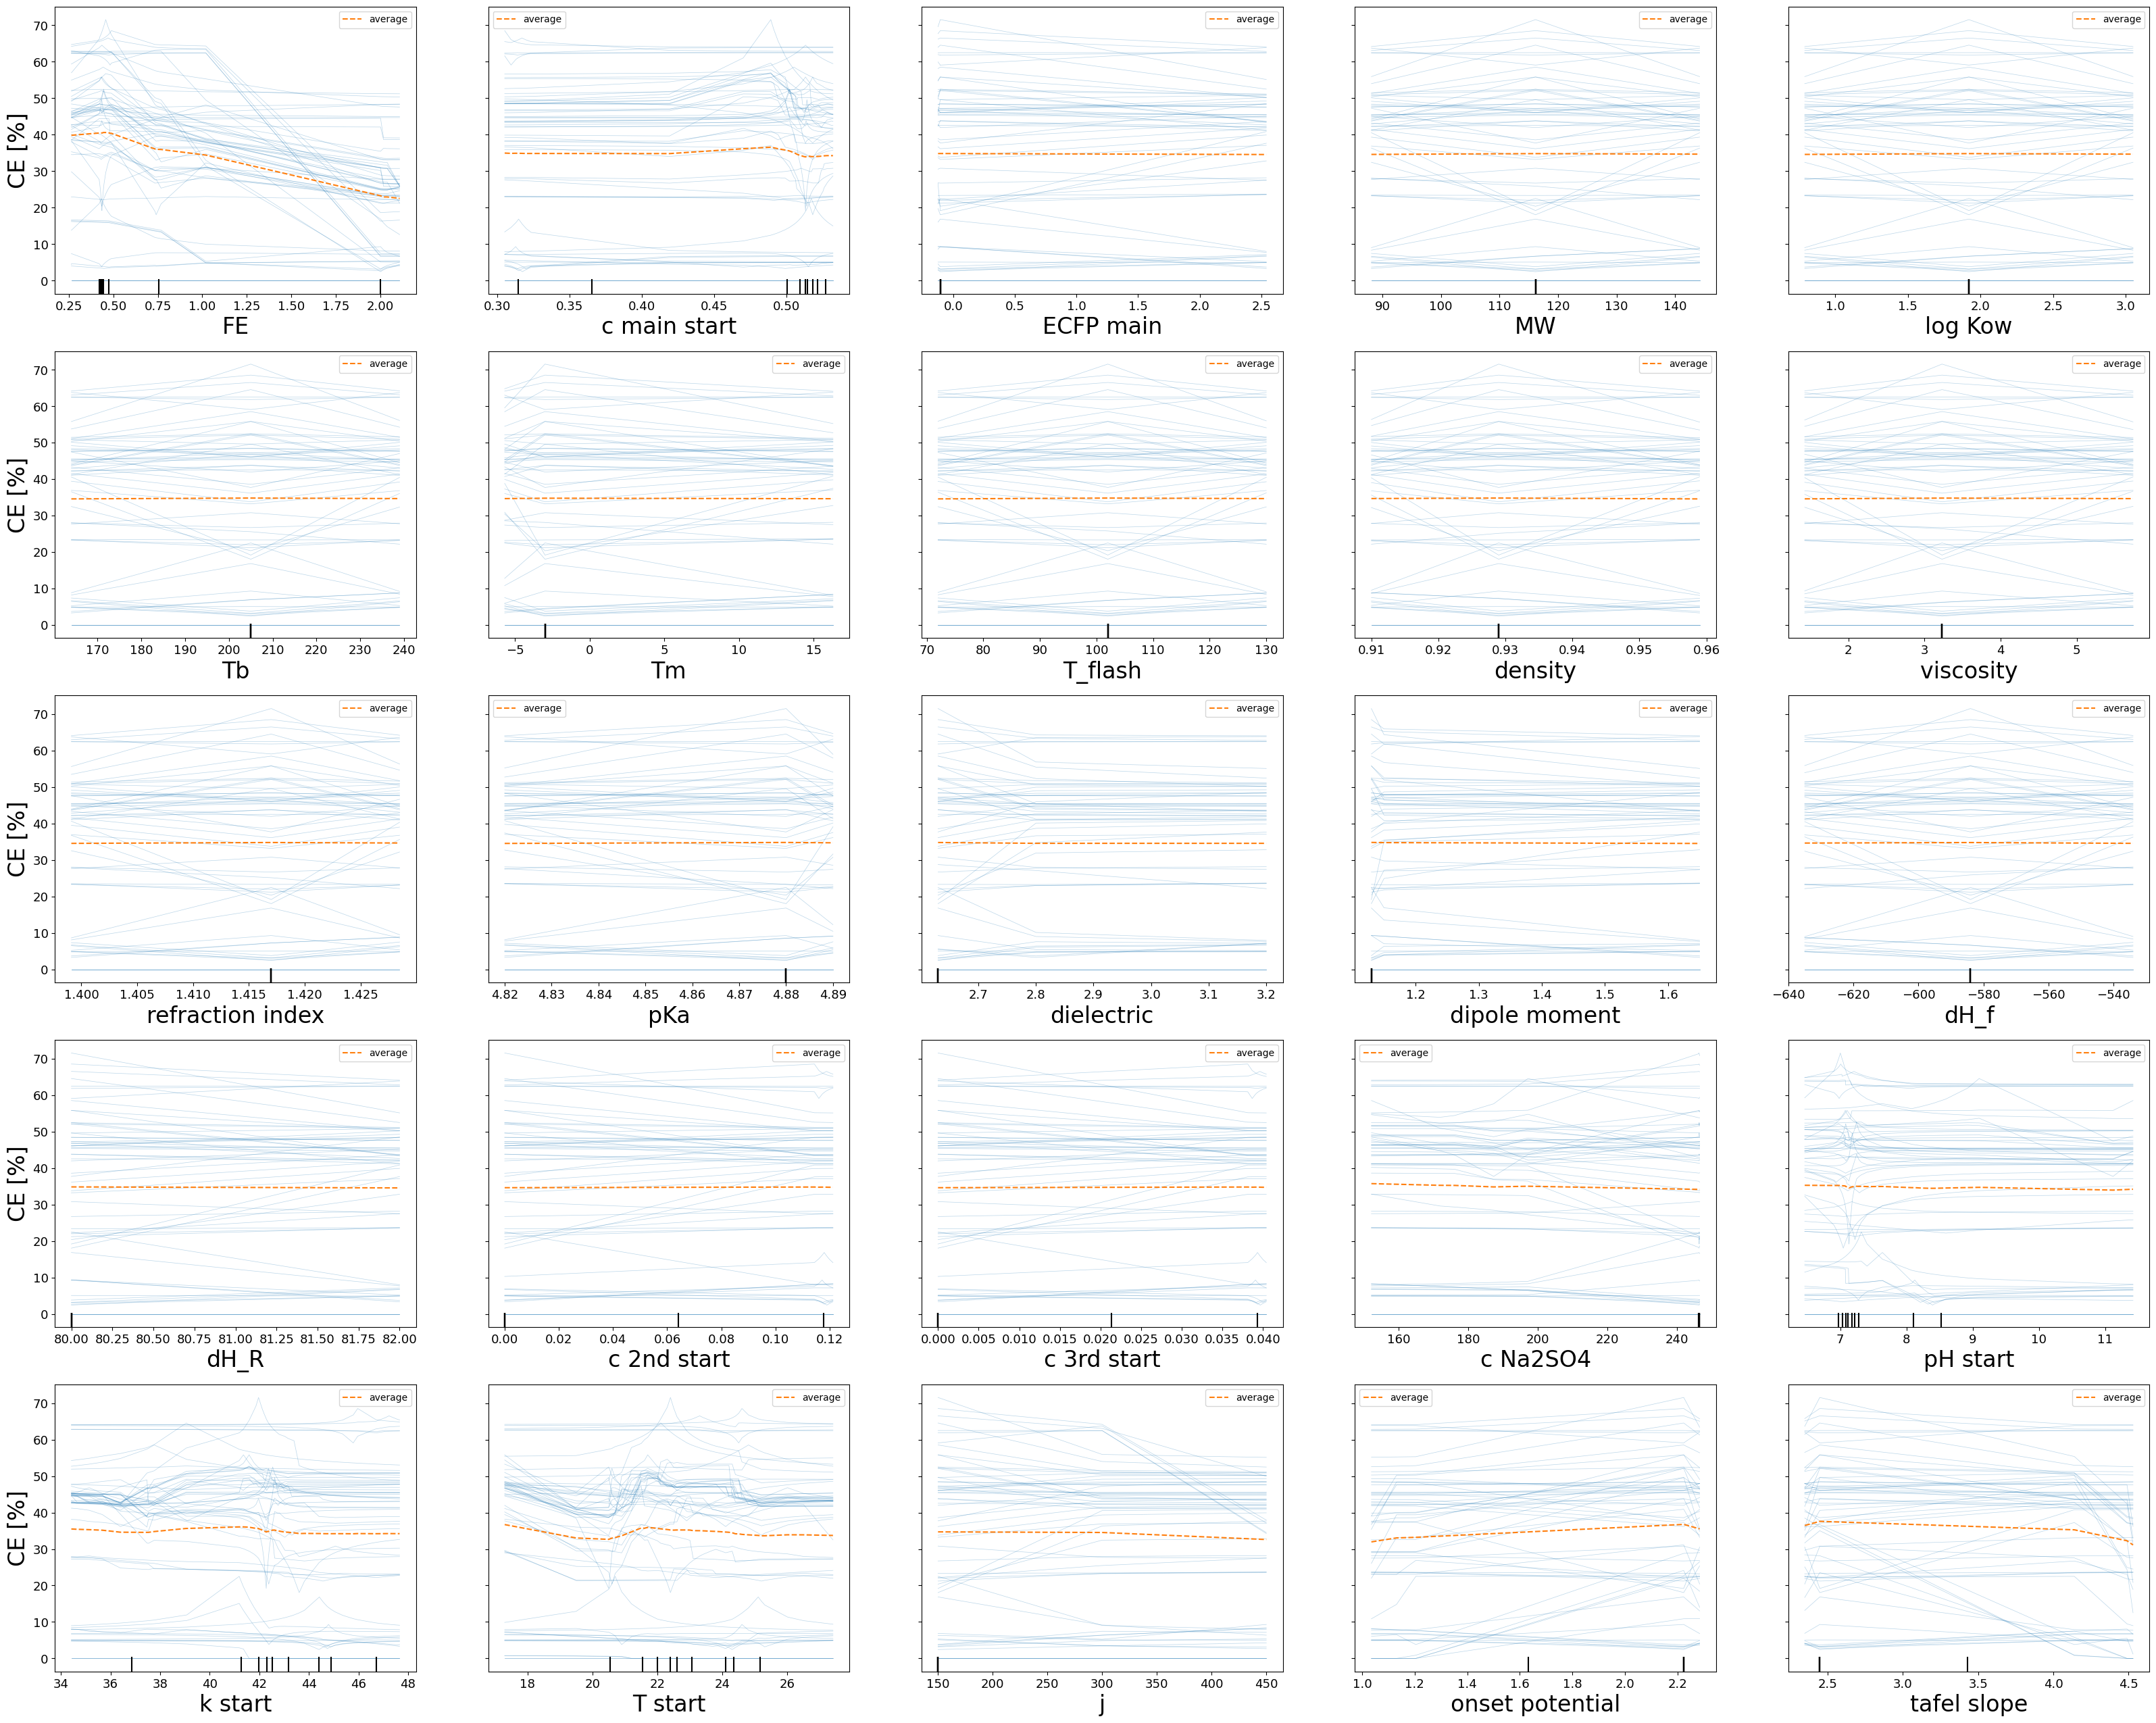

In [15]:
#  Individual conditional expectation (ICE) plot (single instead of averages) 
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', ax=ax#, line_kw={"color": "green"}
                                                 )

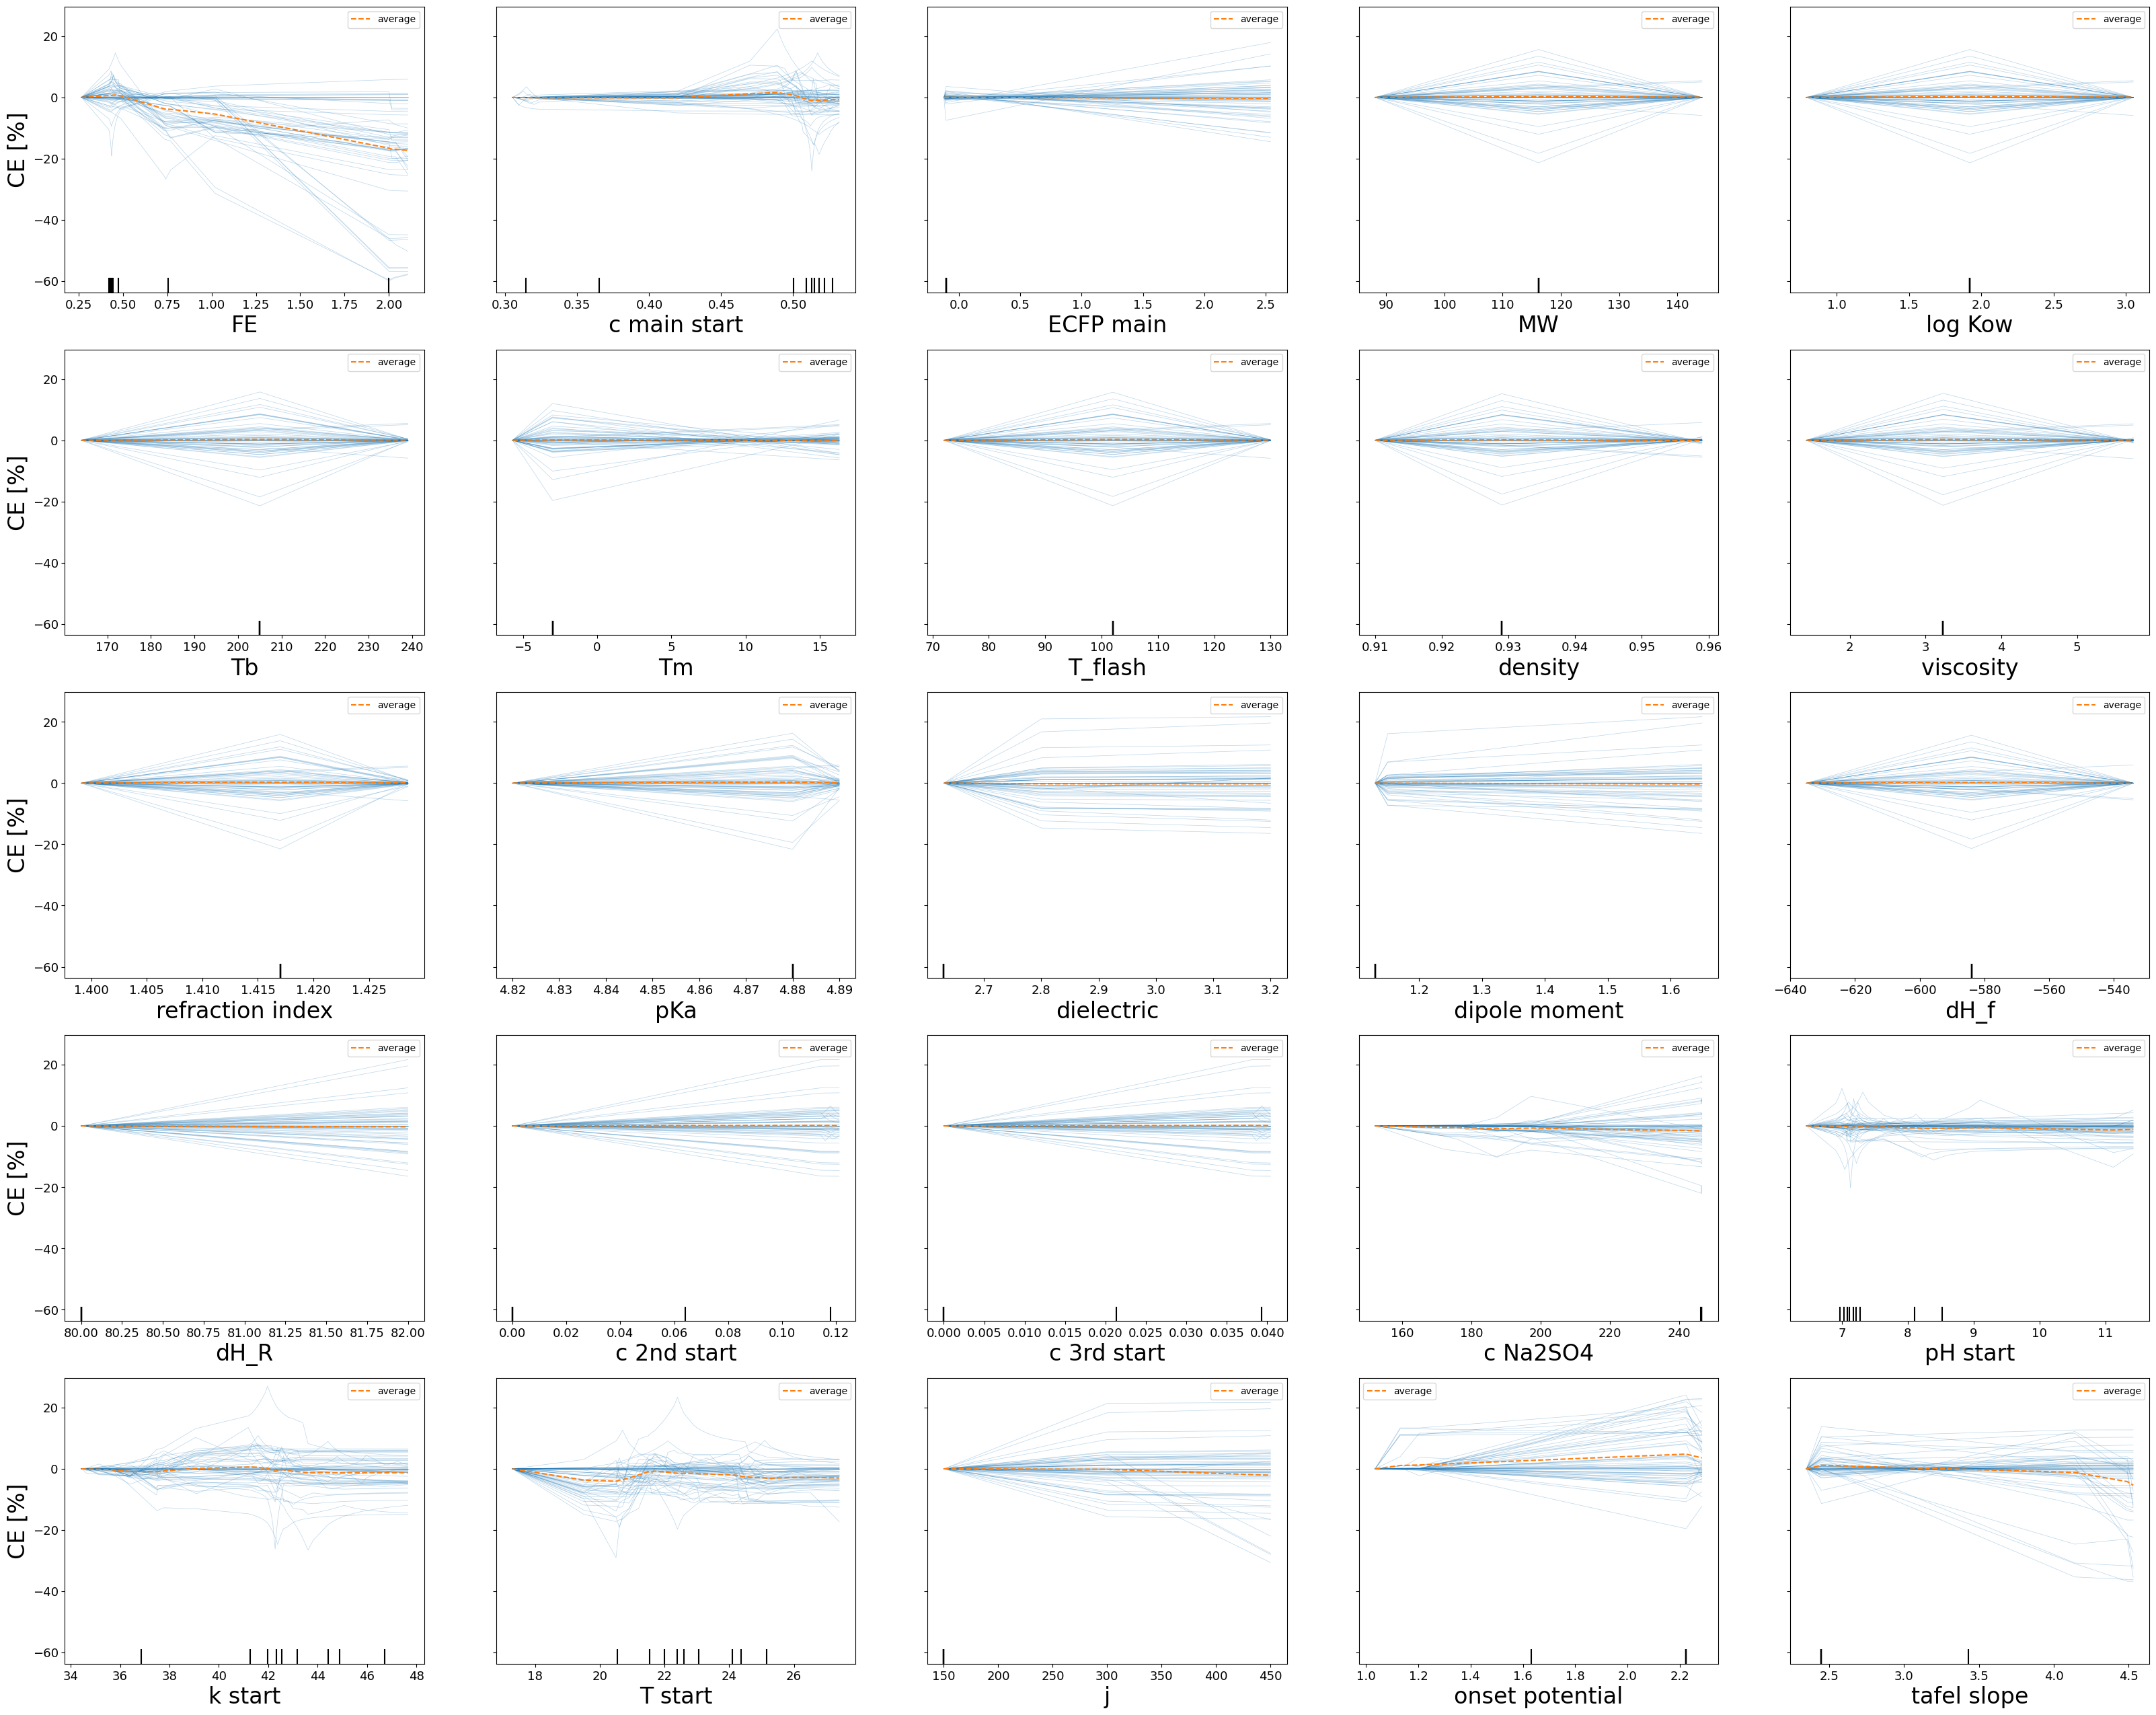

In [16]:
# cICE (centered ICE) and PDP
ax_labelsize = 24
tick_labelsize = 13

ncols = 5
nrows = 5
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 32))
#ax.set_title("PDP")
#fig.suptitle("PDP", y=1.02, fontsize=100) 
#ax.tick_params(axis='both', labelsize=12)

plt.rc('axes', labelsize=ax_labelsize)  # set standard label size axis

for axis in ax.flatten():
    axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks

y_label = output_name    
number_ax = [0, 1, 2, 3, 4]
for i in number_ax:
    ax[i, 0].set_ylabel(y_label)



display = PartialDependenceDisplay.from_estimator(knn_regressor, X_train, features, feature_names=feature_names, kind='both', centered=True, ax=ax#, line_kw={"color": "green"}
                                                 )

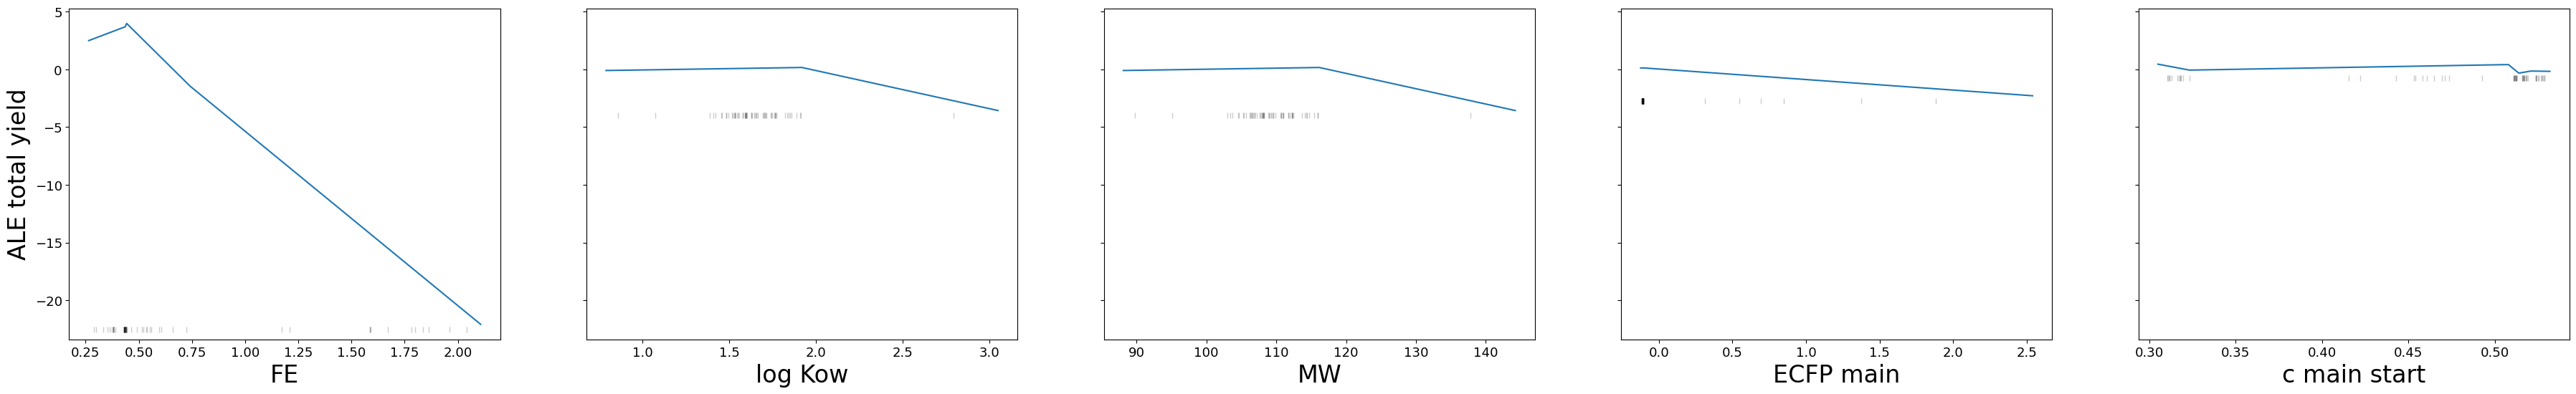

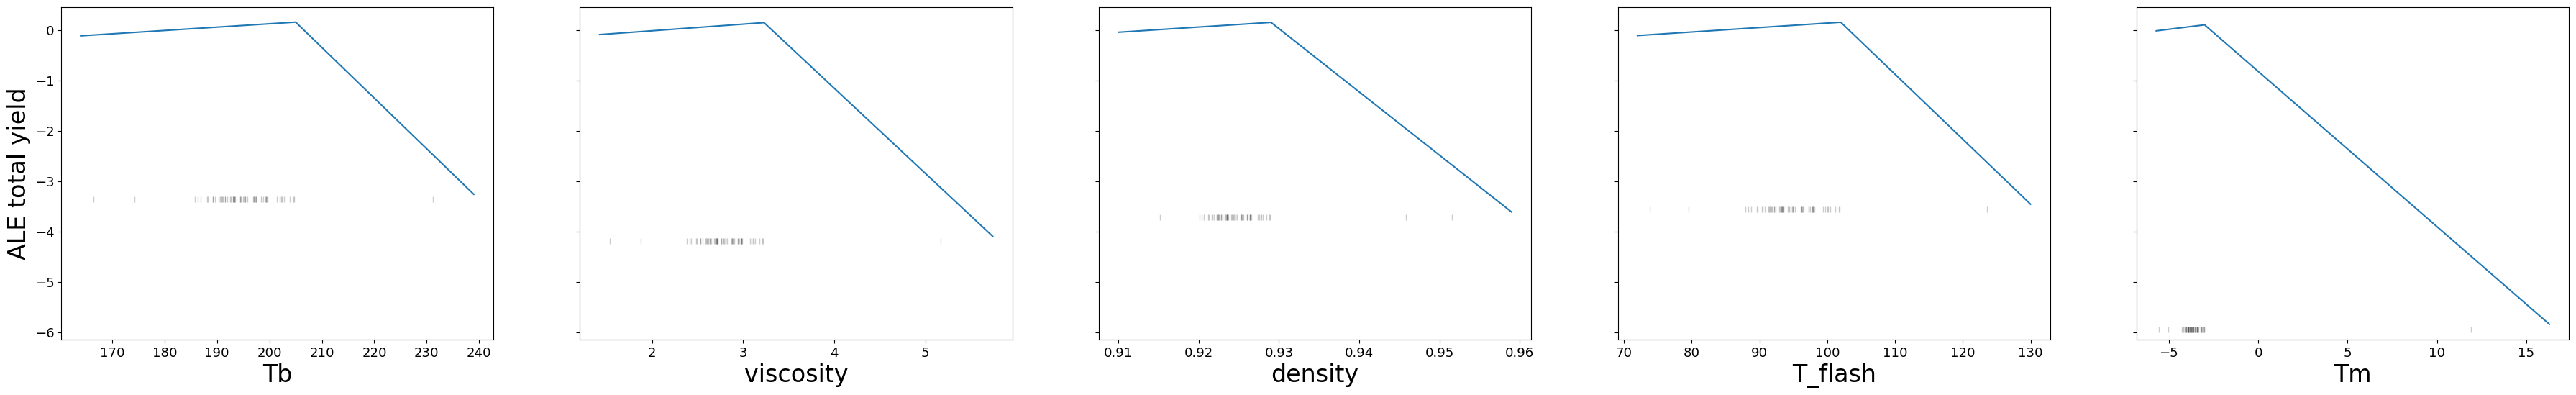

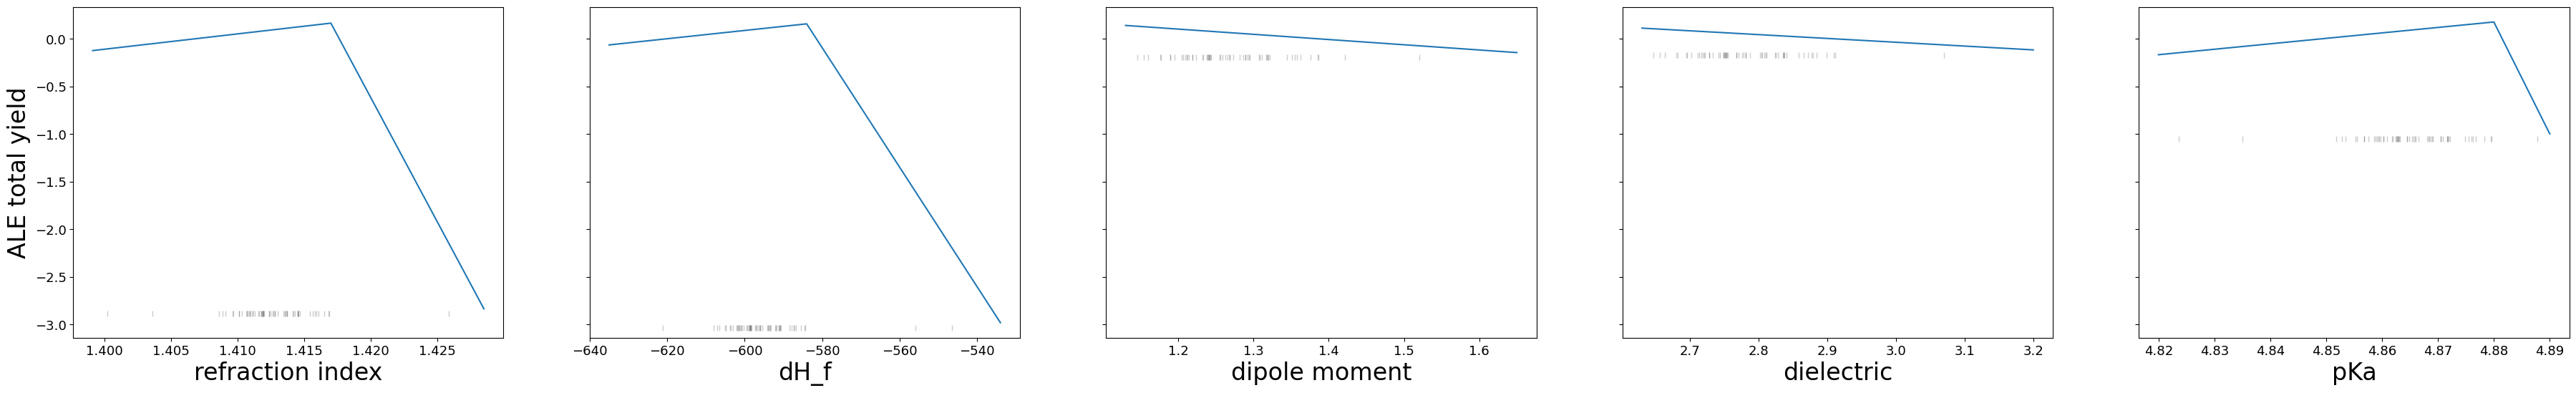

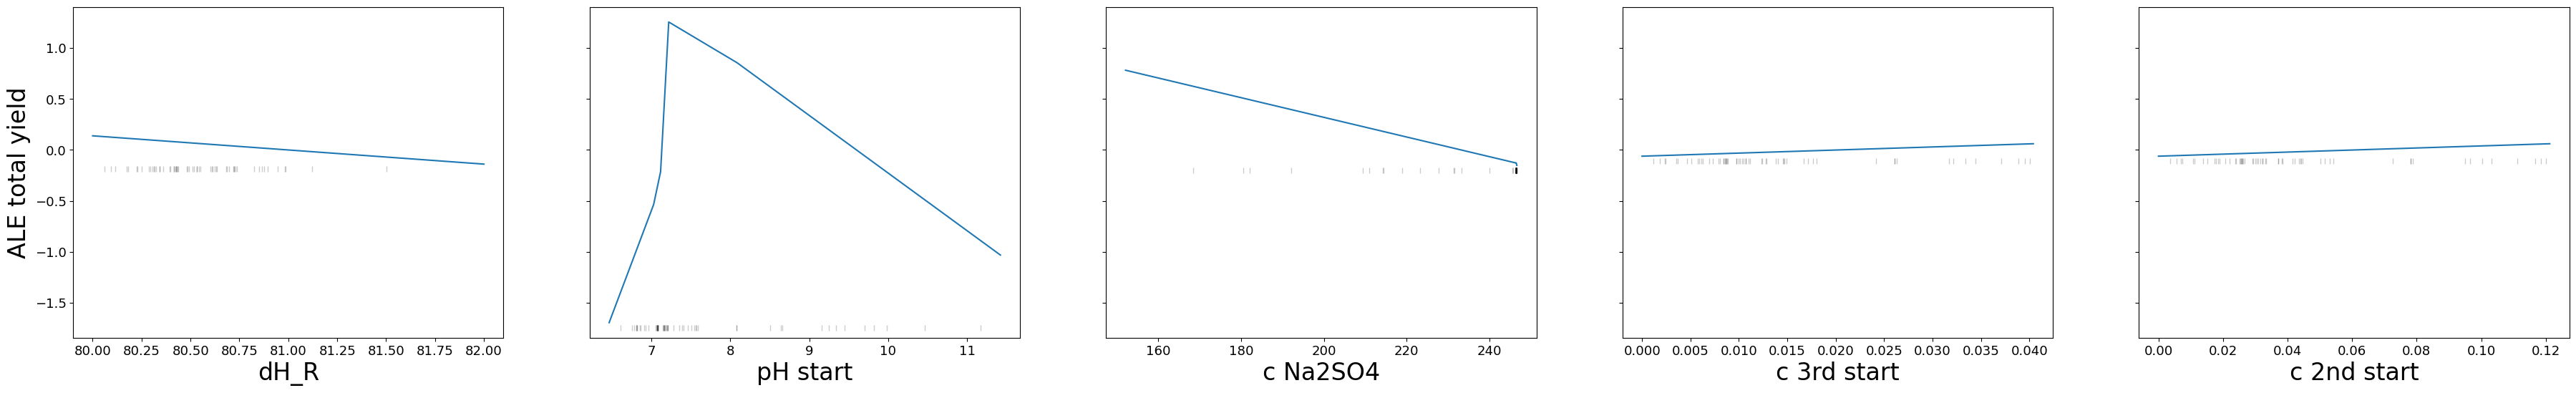

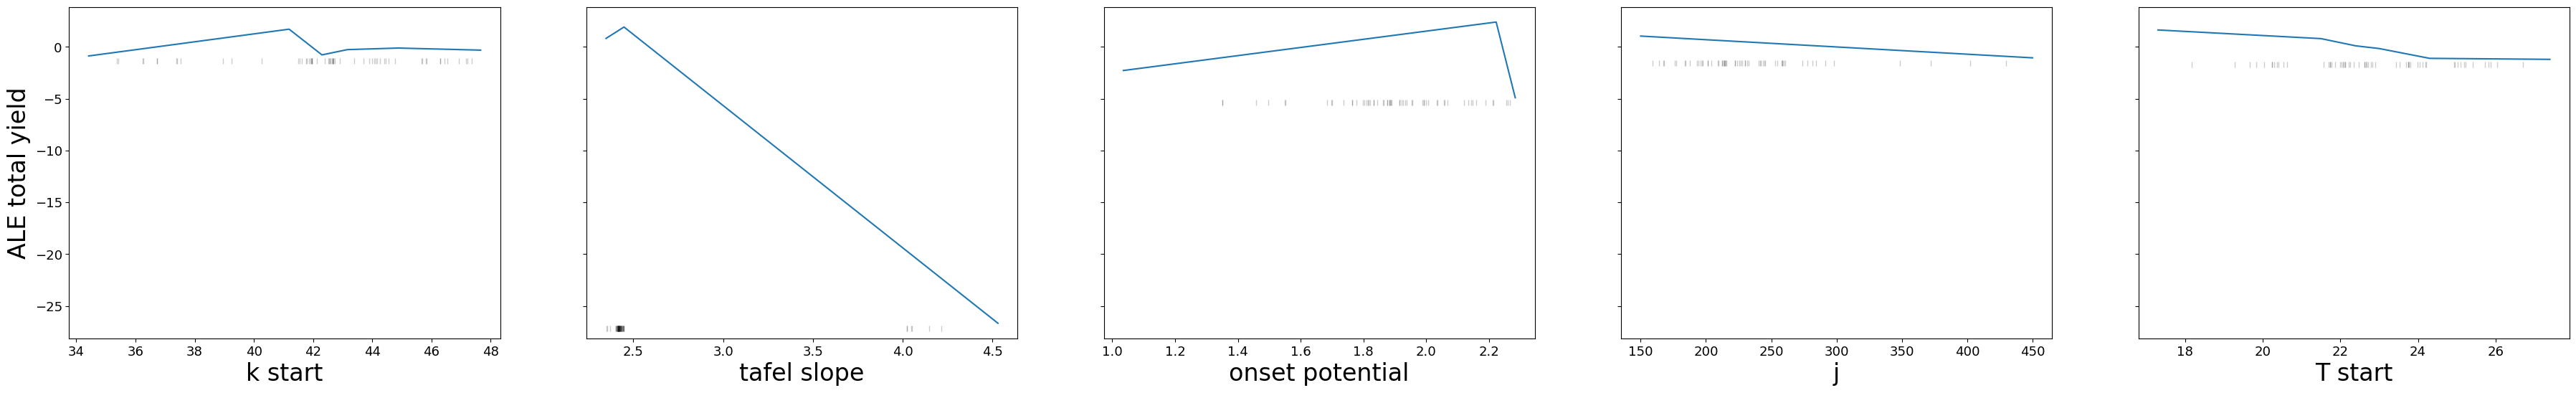

In [17]:
df_train_X = pd.DataFrame(X_train, columns=features)
df_train_Y = pd.DataFrame(Y_train, columns=[output_name])

# get ALE plot

for i in features:
    if i % 5 == 0:
        fig, ax = plt.subplots(ncols=ncols, figsize=(45,6), sharey=True)
        for axis in ax.flatten():
            axis.tick_params(axis='both', labelsize=tick_labelsize) # size of axis ticks
        ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[0]
        )
        ax[0].set_ylabel('ALE total yield')
        ax[0].set_xlabel(feature_names[i])
        ax[0].set_title('')
    else:
        if (i+1) % 5 == 0:
            ale_eff = ale(
            X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
            fig=fig, ax=ax[1]
            )
            ax[1].set_ylabel('')
            ax[1].set_xlabel(feature_names[i])
            ax[1].set_title('')
        else:
            if (i+2) % 5 == 0:
                ale_eff = ale(
                X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                fig=fig, ax=ax[2]
                )
                ax[2].set_ylabel('')
                ax[2].set_xlabel(feature_names[i])
                ax[2].set_title('')
            else:
                if (i+3) % 5 == 0:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[3]
                    )
                    ax[3].set_ylabel('')
                    ax[3].set_xlabel(feature_names[i])
                    ax[3].set_title('')
                else:
                    ale_eff = ale(
                    X=df_train_X, model=knn_regressor, feature=[i], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
                    fig=fig, ax=ax[4]
                    )
                    ax[4].set_ylabel('')
                    ax[4].set_xlabel(feature_names[i])
                    ax[4].set_title('')
    

Text(0.5, 1.0, '')

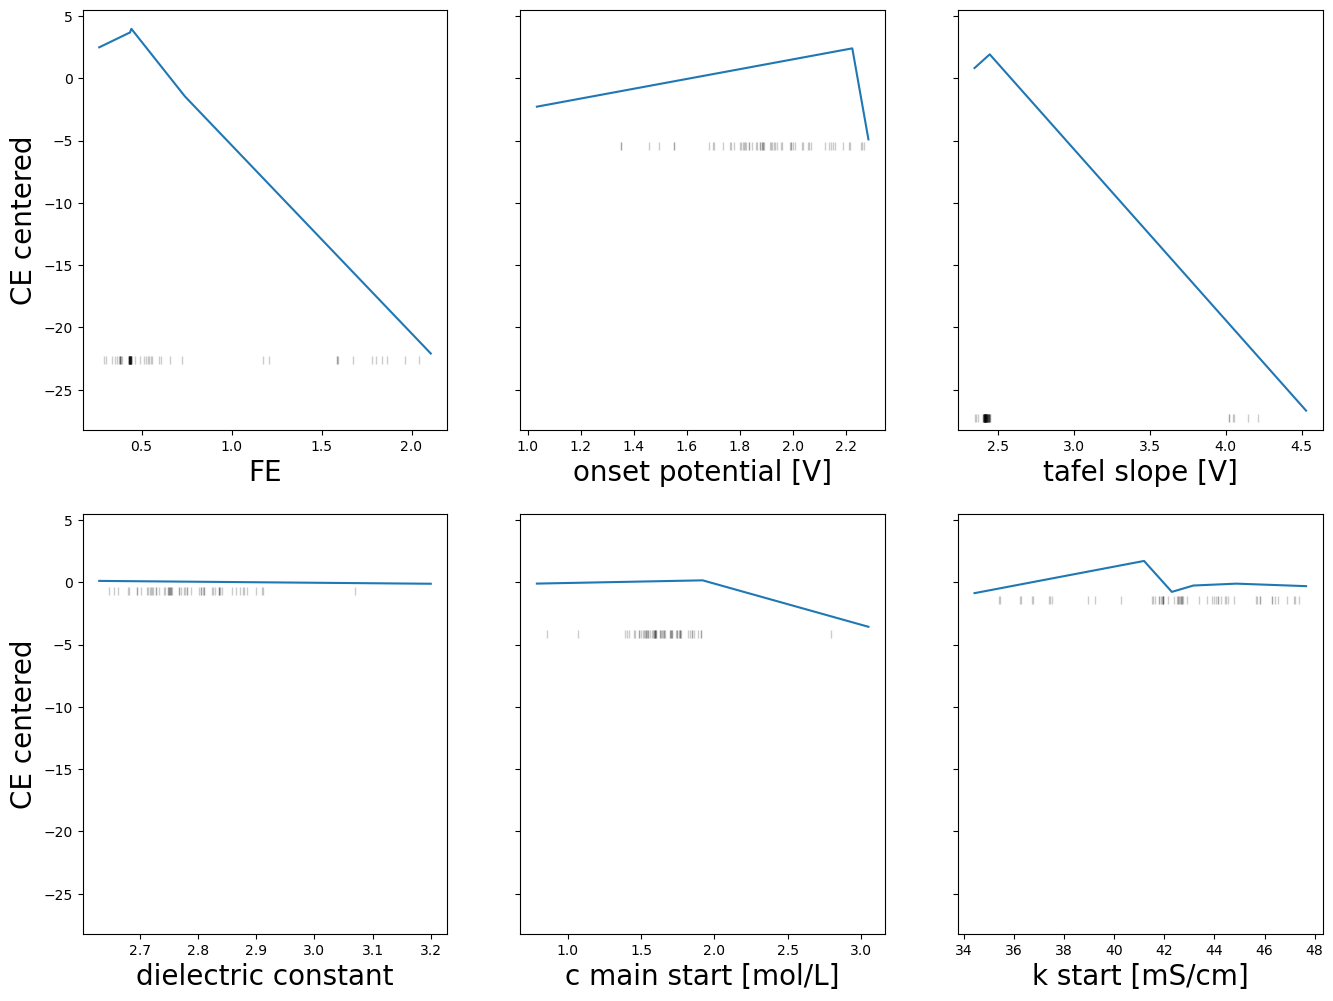

In [59]:
ale_ylabel = 'CE centered'


fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(16,12), sharey=True)

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[0], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,0]
)
ax[0,0].set_ylabel(ale_ylabel)
ax[0,0].set_xlabel(feature_names[0])
ax[0,0].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[23], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,1]
)
ax[0,1].set_ylabel('')
ax[0,1].set_xlabel('onset potential [V]')
ax[0,1].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[24], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[0,2]
)
ax[0,2].set_ylabel('')
ax[0,2].set_xlabel('tafel slope [V]')
ax[0,2].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[12], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,0]
)
ax[1,0].set_ylabel(ale_ylabel)
ax[1,0].set_xlabel('dielectric constant')
ax[1,0].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[1], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,1]
)
ax[1,1].set_ylabel('')
ax[1,1].set_xlabel('c main start [mol/L]')
ax[1,1].set_title('')

ale_eff = ale(
    X=df_train_X, model=knn_regressor, feature=[20], feature_type='continuous', grid_size=5, include_CI=False, #C=0.95,
    fig=fig, ax=ax[1,2]
)
ax[1,2].set_ylabel('')
ax[1,2].set_xlabel('k start [mS/cm]')
ax[1,2].set_title('')

In [18]:
# 2D ale plots


#ax.set_ylabel('ALE total yield')
#ax.set_xlabel(feature_names[i])
#ax.set_title('')



                      Mean   Std Dev
FE                0.475837  0.092515
c main start      0.005773  0.006637
ECFP main         0.003262  0.002799
MW                0.008672  0.003521
log Kow           0.008900  0.003399
Tb                0.007886  0.003222
Tm                0.014062  0.005071
T_flash           0.008459  0.003237
density           0.007426  0.003252
viscosity         0.009738  0.003850
refraction index  0.007321  0.003020
pKa               0.004417  0.002648
dielectric        0.016744  0.005734
dipole moment     0.003614  0.002642
dH_f              0.008879  0.003555
dH_R              0.003089  0.002654
c 2nd start       0.002427  0.004256
c 3rd start       0.002911  0.003909
c Na2SO4         -0.006949  0.004206
pH start          0.005104  0.002605
k start           0.011624  0.008455
T start           0.006931  0.008813
j                 0.002158  0.002284
onset potential   0.132920  0.039741
tafel slope       0.248796  0.067008


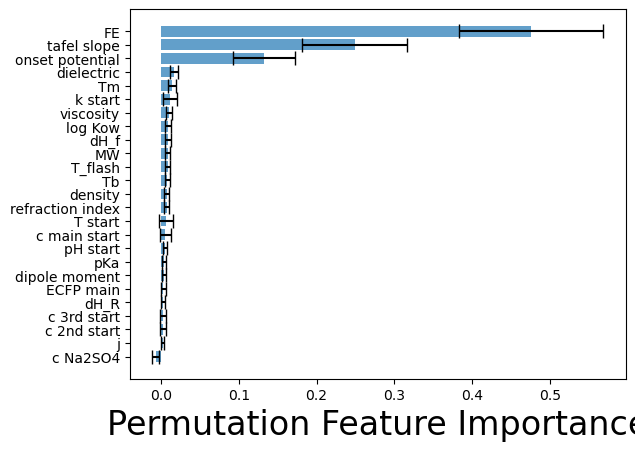

In [19]:
# permutation feature importance on test data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_test)
baseline_mse = mse(Y_test, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_test.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()

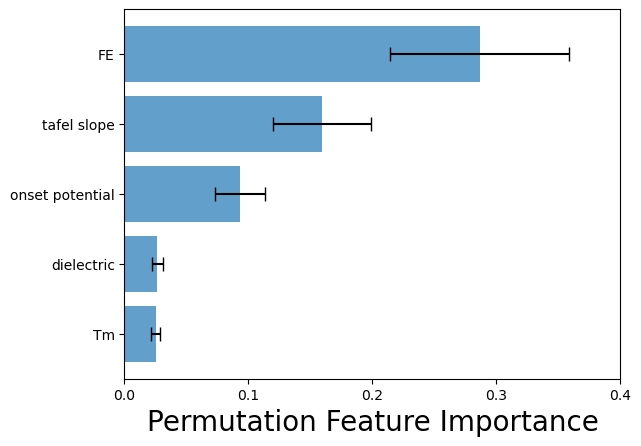

In [29]:
plt.rc('axes', labelsize=20) #size of laabel axis

# Choose the top 6 features
top_feature_indices = sorted_indices[-5:]
top_feature_names = sorted_feature_names[-5:]

plt.barh(range(len(top_feature_indices)), mean_values[top_feature_indices], xerr=std_dev_values[top_feature_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(len(top_feature_indices)), top_feature_names)  # Use top_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.xticks(np.arange(0, 0.41, 0.1))
plt.show()

                      Mean   Std Dev
FE                0.286426  0.072189
c main start      0.020508  0.004282
ECFP main         0.019263  0.002793
MW                0.022062  0.002905
log Kow           0.022202  0.003040
Tb                0.021812  0.002952
Tm                0.025157  0.003593
T_flash           0.022045  0.002950
density           0.021399  0.002733
viscosity         0.022816  0.003018
refraction index  0.021266  0.002820
pKa               0.019748  0.002669
dielectric        0.026556  0.004148
dipole moment     0.019390  0.002568
dH_f              0.022192  0.002951
dH_R              0.019167  0.002626
c 2nd start       0.018984  0.002988
c 3rd start       0.018940  0.003073
c Na2SO4          0.013162  0.002494
pH start          0.020220  0.002635
k start           0.024268  0.005312
T start           0.020902  0.005043
j                 0.018561  0.002385
onset potential   0.093466  0.020246
tafel slope       0.159488  0.039425


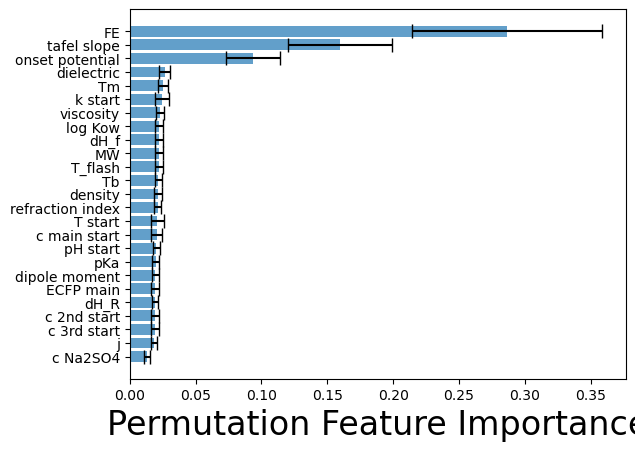

In [20]:
# permutation feature importance on training data

# Initialize list
row_list = []

# Function to calculate mean squared error
def mse(Y_true, Y_pred):
    return mean_squared_error(Y_true, Y_pred)

# Calculate the baseline mean squared error
baseline_pred = knn_regressor.predict(X_train)
baseline_mse = mse(Y_train, baseline_pred)

# Initialize an array to store feature importances
feature_importances = np.zeros(X_train.shape[1])


runs = 500

for j in range(runs):
    
    # Perform permutation feature importance
    for i in range(X_test.shape[1]):
        
        # Permute the values of the i-th feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Predict using the model with permuted feature
        permuted_pred = knn_regressor.predict(X_permuted)

        # Calculate mean squared error with permuted feature
        permuted_mse = mse(Y_test, permuted_pred)

        # Calculate feature importance
        feature_importances[i] = baseline_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()
    
    # Create a new row in the DataFrame
    row_list.append(dict(zip(feature_names, feature_importances)))
    

    #df_feature_importances.loc[len(df_feature_importances)] = feature_importances
    df_feature_importances=pd.DataFrame(row_list, columns=feature_names)

# Calculate mean of each column
mean_values = df_feature_importances.mean()

# Calculate standard deviation of each column
std_dev_values = df_feature_importances.std()

# Append mean and standard deviation as rows to the DataFrame
df_feature_importances = pd.concat([df_feature_importances, mean_values.to_frame().transpose(), std_dev_values.to_frame().transpose()], ignore_index=True)

# You may want to add appropriate row labels, for example:
df_feature_importances = df_feature_importances.rename({len(df_feature_importances) - 2: 'Mean', len(df_feature_importances) - 1: 'Std Dev'})

df_feature_importances = pd.DataFrame({'Mean': mean_values, 'Std Dev': std_dev_values})
df_feature_importances.index = feature_names

# Display the DataFrame with mean and standard deviation rows

print(df_feature_importances)
df_feature_importances.to_csv('feature_importances.csv', index=False, mode='w')


# Sort and plot the feature importances
sorted_indices = np.argsort(mean_values)
sorted_feature_names = np.array(feature_names)[sorted_indices]  # Use feature_names array

plt.barh(range(X_test.shape[1]), mean_values[sorted_indices], xerr=std_dev_values[sorted_indices], align='center', alpha=0.7, capsize=5)
plt.yticks(range(X_test.shape[1]), sorted_feature_names)  # Use sorted_feature_names for y-axis ticks
plt.xlabel('Permutation Feature Importance')
plt.show()